<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/notebooks/02_Equilibre_Long_Terme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf Cours-EcoElec
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp as pl
import config


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 107 (delta 41), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 1.55 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/Cours-EcoElec/notebooks
01_Equilibre_Court_Terme_correction.ipynb  config.py
01_Equilibre_Court_Terme_énoncé.ipynb	   Consommation_France_2024.csv
02_Equilibre_Long_Terme.ipynb		   Disponibilites_2024.csv


# Méthode des screening curves

Text(0.5, 0, "Nombre d'heure")

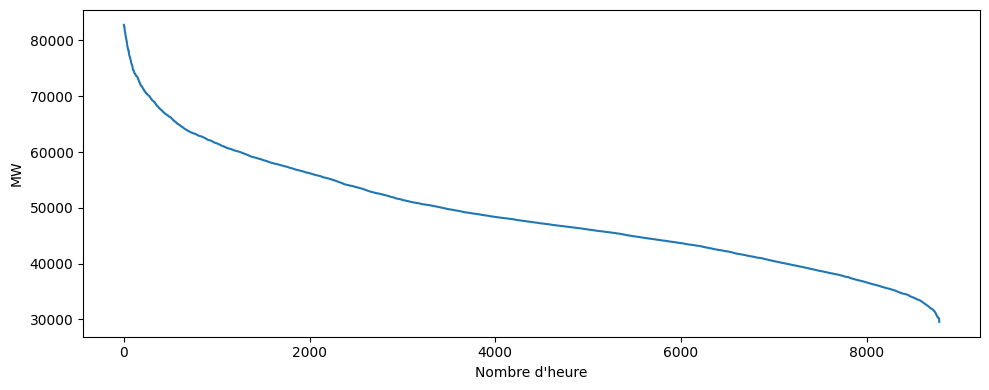

In [3]:

# Import des données
df = pd.read_csv("Consommation_France_2024.csv",index_col=0)
df["heure"] = pd.to_datetime(df["heure"])


# Visualisation de l'évolution annuelle de la consommation réalisée

fig, ax = plt.subplots(tight_layout=True,figsize =(10,4))

monotone = df["Consommation réalisée (MW)"].sort_values(ascending=False).values

ax.plot(monotone)

ax.set_ylabel("MW")
ax.set_xlabel("Nombre d'heure")


In [4]:
print(monotone[3000])

51420.0


In [6]:

donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 10000}
}

(0.0, 500.0)

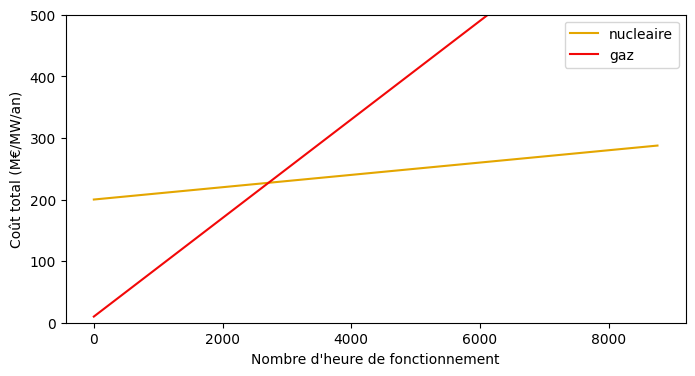

In [8]:
fig, ax = plt.subplots(figsize=(8,4))

t = np.arange(8760)

for i in donnees_filieres :

  cost_curve = donnees_filieres[i]["cout_fixe"] + donnees_filieres[i]["cout_variable"]*t
  ax.plot(cost_curve / 1000,
          label = i,
          color = config.couleurs[i])

ax.set_xlabel("Nombre d'heure de fonctionnement")
ax.set_ylabel("Coût total (M€/MW/an)")

ax.legend(loc="best")
ax.set_ylim([0,500])

# Méthode optim